# Demo: Calibrating Mixture Proportions in a GMM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/smithhenryd/cgm/blob/main/neural_sde/gmm_example.ipynb)

In this notebook, we demonstrate how CGM-relax and CGM-reward can be employed to calibrate a diffusion generative model on a simple mode reweighting task. In this notebook we will:

I. Train a diffusion model $p_{\theta_{\text{base}}}(\boldsymbol{x})$ to generate samples from a 1D Gaussian mixture model with well-separated modes:
\begin{align*}
p_{\theta_{\text{base}}}(\boldsymbol{x}(1)) \approx q_{\text{base}} = (1/2) \mathcal{N}(-1, (1/4)^2) + (1/2) \mathcal{N}(+1, (1/4)^2). \quad (1)
\end{align*}
Here, $\boldsymbol{x}(1)$ represents the terminal time of the diffusion process, defined for times $0 \leq t \leq 1$. Time $t = 0$ represents $\mathcal{N}(0, 1)$ standard Gaussian noise.

II. Use CGM-relax and CGM-reward to reweight the proportion of mass that lies in each mode. By choosing the calibration constraint $\boldsymbol{h}(\boldsymbol{x}) = 1\{\boldsymbol{x}(1) > 0\}$ and a desired mixture proportion $\boldsymbol{h}^\ast$, we can effectively reweight the proportion of mass that lies in each mode. That is to say, we can fine-tune the base diffusion sampler so that it generates samples from
\begin{align*}
p_{\theta'}(\boldsymbol{x}(1)) \approx q_{\text{calibrated}} = (1-\boldsymbol{h}^\ast) \mathcal{N}(-1, (1/4)^2) + \boldsymbol{h}^\ast \mathcal{N}(+1, (1/4)^2).
\end{align*}


## I. Training the base model

### Background: Continuous-time Diffusion Models
We first train the base diffusion model $p_{\theta_{\text{base}}}$ to generate samples from $(1)$. We do this by modeling $p_{\theta_{\text{base}}}$ as the reversal of a noising process 
\begin{align*}
\vec{p}: d\boldsymbol{x}(t) = \frac{1}{2} \kappa(t) \boldsymbol{x}(t) dt + \sqrt{\kappa(t)} d\boldsymbol{w}(t), \quad 0 \leq t \leq 1, \quad \vec{p}(\boldsymbol{x}(1)) = q_{\text{base}} \quad (2)
\end{align*}
where $(\boldsymbol{w}(t))_{0 \leq t \leq 1}$ is a standard Brownian motion and $(\kappa(t))_{0 \leq t \leq 1}$ is a noising schedule. Notice that the SDE runs backward in time starting from $t=1$. The marginals of the noising process satisfy $p(\boldsymbol{x}(t) | \boldsymbol{x}(1)) = \mathcal{N}(\boldsymbol{x}(t) | m(t)\boldsymbol{x}(1), \sigma(t)^2 \mathbb{I})$, where
\begin{align*}
&m(t) = \exp \left\{ -\frac{1}{2}\int_t^1 \kappa(u) du \right\}\\
&\sigma^2(t) = \int_t^1  \kappa(u) \exp \left\{  -  \int_t^u \kappa(w) dw\right\} du = 1 - \exp \left\{  -  \int_t^1 \kappa(w) dw\right\}.
\end{align*}
Choosing $\kappa$ such that $\int_0^1 \kappa(t) dt = +\infty$ yields Gaussian noise at time $t=0$ under the noising process $\vec{p}$. In this example we choose $\kappa(t) = t^{-1}$, which yields $m(t) = t^{1/2}$ and $\sigma(t) = (1-t)^{1/2}$.

To construct a generative model $p_{\theta_{\text{base}}}$ that samples from $q_{\text{base}}$ i.e. $p_{\theta_{\text{base}}}(\boldsymbol{x}(1)) \approx q_{\text{base}}$, it suffices to learn the score $\nabla_{\boldsymbol{x}} \log \vec{p}(\boldsymbol{x}, t)$ of the noising process. This is because
\begin{align*}
p: d\boldsymbol{x}(t) = \left\{\sigma(t)^2\nabla_{\boldsymbol{x}} \log \vec{p}(\boldsymbol{x}(t), t) + \frac{1}{2} \kappa(t) \boldsymbol{x}(t) \right\}dt + \sqrt{\kappa(t)} d\boldsymbol{w}(t), \quad p_{\theta_{\text{base}}}(\boldsymbol{x}(0)) = \mathcal{N}(\boldsymbol{0}, \mathbb{I}) \quad (3)
\end{align*}
is the reversal of equation $(2)$, meaning that it satisfies $p(\boldsymbol{x}(1)) = q_{\text{base}}$ (Anderson, 1982). In practice, we define $p_{\theta_{\text{base}}}$ as in $(3)$, but with the score replaced by $\boldsymbol{s}_{\theta}(\boldsymbol{x}, t)$, a neural network approximation to the score. Training the diffusion model then amounts to regressing $\boldsymbol{s}_{\theta}(\boldsymbol{x}, t)$ on $\nabla_{\boldsymbol{x}} \log \vec{p}(\boldsymbol{x}(t), t | \boldsymbol{x}(1))$. For additional details, see (Song, 2021).


**References**:

• Brian Anderson. Reverse-time diffusion equation models. _Stochastic Processes and their Applications_, 1982.

• Yang Song, Jascha Sohl-Dickstein, Diederik P Kingma, Abhishek Kumar, Stefano Ermon, and Ben Poole. Score-based generative modeling through stochastic differential equations. _ICLR_, 2021.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# If running notebook in Google Colab, clone repo and install dependencies 
import sys, os, subprocess
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB: 
    # Clone the repo (replace with your repo path)
    repo_url = "https://github.com/smithhenryd/cgm.git"
    repo_dir = "/content/cgm"

    if not os.path.exists(repo_dir):
        print(f"Cloning {repo_url}...")
        subprocess.run(["git", "clone", repo_url, repo_dir], check=True)

    # Install cgm dependencies not in Colab
    def ensure_pkg(pkg):
        try:
            __import__(pkg)
        except ImportError:
            print(f"Installing {pkg} ...")
            subprocess.run(["pip", "install", "-q", pkg], check=True)

    for pkg in ["tqdm", "cvxpy"]:
        ensure_pkg(pkg)

    # Run cgm install
    subprocess.run(["pip", "install", "-e", repo_dir, "--no-deps", "-q"], check=True)
    print("Successfully installed package cgm")

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

from math import log, exp

from utils import kappa, m, sigma, ScoreNetwork, train_neural_sde, BackwardDrift
from neural_sde import NeuralSDE
from plotting import plot_1d_density, plot_nsde_marginals

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Visualize the conditional mean and standard deviation of the noising process:

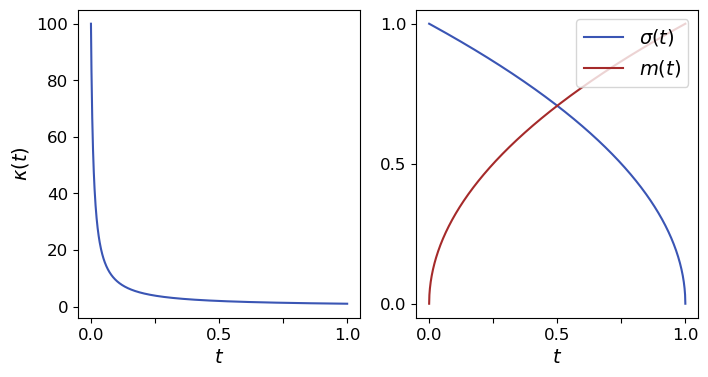

In [5]:
colors = [
    "#3a55b4",
    "#A52A2A",
]

labelsize = 12
fontsize = 14
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ts = torch.linspace(0, 1.0, 1000)
axs[0].plot(ts, kappa(1. - ts), color=colors[0])
axs[1].plot(1. - ts, m(1. - ts), color=colors[0], label=r"$\sigma(t)$")
axs[1].plot(1. - ts, sigma(1. - ts), color=colors[1], label=r"$m(t)$")

axs[1].legend(loc="upper right", fontsize=fontsize)

axs[0].set_ylabel(r"$\kappa(t)$", fontsize=fontsize)

for i in range(2):
    axs[i].set_xlabel(r"$t$", fontsize=fontsize)
    axs[i].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    axs[i].set_xticklabels(["0.0", "", "0.5", "", "1.0"])
    axs[i].tick_params(axis='both', which='major', labelsize=labelsize)

axs[1].set_yticks([0.0, 0.5, 1.0])
axs[1].set_yticklabels(["0.0", "0.5", "1.0"], fontsize=labelsize)

plt.show()

And visualize the Gaussian mixture model density from which we'd like to sample:

In [6]:
from math import pi
from typing import Type


def q_GMM_batch(
    x: torch.Tensor,
    means: torch.Tensor,
    cov: torch.Tensor,
    mixture_props: torch.Tensor,
    eps: float = 1e-5,
):
    """
    Evaluates the density of a GMM with common covariance on x of shape [batch_size, d]
    """

    cov_reg = cov + eps * torch.eye(x.shape[1], dtype=x.dtype, device=x.device)
    sigma_inv = torch.linalg.inv(cov_reg)
    det_sigma = torch.det(cov_reg)
    norm_const = ((2 * pi) ** (-x.shape[1] / 2)) * (det_sigma ** (-1 / 2))

    diff = x[:, None, :] - means[None, :, :]
    exp_term = torch.einsum("nkd,dd,nkd->nk", diff, sigma_inv, diff)
    component_pdf = norm_const * torch.exp(-0.5 * exp_term)
    pdf_values = component_pdf @ mixture_props
    return pdf_values


class GMM:
    """
    A class representing a Gaussian mixture model with specified means, mixture proportions, and common covariance
    """

    def __init__(
        self, means: torch.Tensor, cov: torch.Tensor, mixture_props: torch.Tensor
    ):
        super().__init__()
        self.means = means
        self.cov = cov
        self.mixture_props = mixture_props

    def sample(self, N: int):
        chol_factor = torch.linalg.cholesky(self.cov)
        idx = torch.multinomial(self.mixture_props, N, replacement=True)
        chosen_means = self.means[idx]
        base_samples = torch.randn(
            N, self.cov.shape[0], device=self.cov.device, dtype=self.cov.dtype
        )
        return base_samples @ chol_factor.T + chosen_means

    def density(self, x: torch.Tensor):
        return q_GMM_batch(x, self.means, self.cov, self.mixture_props)

    def density_convolved(self, x: torch.Tensor, m: torch.Tensor, S: torch.Tensor):
        """
        Compute the density of the GMM convolved with a Gaussian N(x|m, S) distribution
        """
        means_new = m * self.means
        cov_new = (m**2) * self.cov + S
        return q_GMM_batch(x, means_new, cov_new, self.mixture_props)

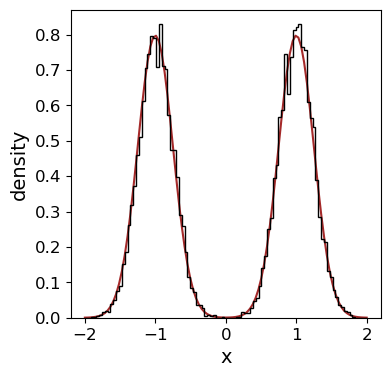

In [7]:
means = torch.tensor([[-1.0], [1.0]])
cov = torch.tensor([[(0.25) ** 2]])
mixture_props = torch.tensor([0.5, 0.5])
gmm = GMM(means, cov, mixture_props)

Nsamps = 10**4
x0s = gmm.sample(Nsamps)  # samples from GMM

bins = torch.linspace(-2.0, 2.0, 100)
fig, ax = plot_1d_density(
    lambda x: gmm.density(x.unsqueeze(-1)),
    figsize=(4, 4),
    xlim=(-2, 2),
    color=colors[1],
)
ax.hist(x0s.reshape(-1), bins, histtype="step", color="black", density=True)
plt.show()

### Run training

In [8]:
x0s = gmm.sample(Nsamps).to(device)
llambda = lambda t: t # since sigma(t)^2 = (1-t)

num_epochs, num_batches, batch_size = 10000, 1, 256  # parameters for training
score_network = ScoreNetwork(
    input_dim=1, hidden_dim=256, time_emb_dim=32, device=device
)  # neural network for learning the score of the forward noising process
score_network = train_neural_sde(
    x0s,
    score_network,
    mean_fn=m,
    std_fn=sigma,
    llambda=llambda,
    epochs=num_epochs,
    batches=num_batches,
    batch_size=batch_size,
    optimizer_cls=optim.Adam,
    optimizer_params={"lr": 1e-3},
    lr_scheduler_cls=optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={"T_max": num_epochs, "eta_min": 1e-5},
    logger=None,
)

Training Epochs: 100%|██████████| 10000/10000 [00:18<00:00, 550.93it/s, loss=0.4339]


### Visualize results from training

In [9]:
# Define the drift and diffusion functions of the forward process
forward_drift = lambda x, t: (-1 / 2) * kappa(t).unsqueeze(-1) * x
forward_diffusion = lambda t: torch.sqrt(kappa(t))

# Define the drift function of the learned backward process
backward_drift = BackwardDrift(score_network, forward_drift, forward_diffusion)

# Construct a neural-SDE using the backward drift
t_grid = torch.linspace(0, 1, 1000, device=device)
base_model = NeuralSDE(
    sde_dim=1,
    drift=backward_drift,
    diffusion=(lambda t: torch.sqrt(kappa(1.0 - t))),
    t_grid=t_grid,
)

Overlay samples from the learned backward process on the true GMM density:

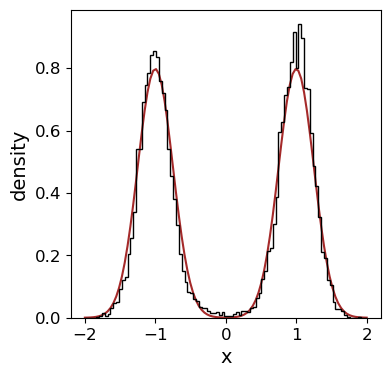

In [10]:
with torch.no_grad():
    samps = base_model.sample(Nsamps)  # Sample from the learned backward process
samps = samps.xs[:, -1, 0].cpu()

fig, ax = plot_1d_density(
    lambda x: gmm.density(x.unsqueeze(-1)),
    figsize=(4, 4),
    xlim=(-2, 2),
    color=colors[1],
)
ax.hist(samps.reshape(-1), bins, histtype="step", color="black", density=True)
plt.show()

Visualize the learned reversal of the noising process, defined by $\boldsymbol{s}_{\theta}(\boldsymbol{x}(t), t)$, together with the analytical reversal, defined by $\nabla_{\boldsymbol{x}} \log \vec{p}(\boldsymbol{x}(t), t)$:

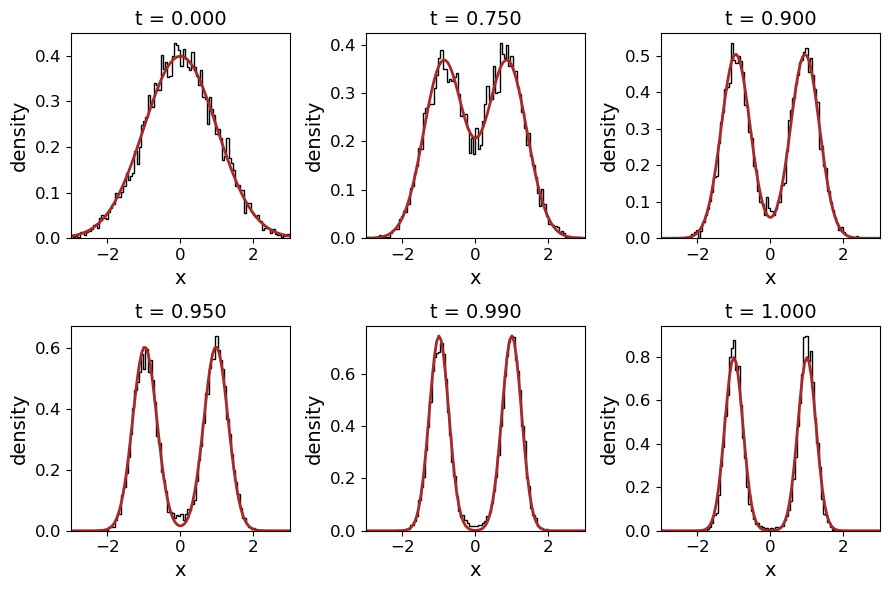

In [11]:
def plot_marginals_and_gmm_density(
    model: NeuralSDE,
    gmm: GMM,
    Nsamps: int,
    ts: list = [0.0, 0.75, 0.9, 0.95, 0.99, 1.0],
    xlim=(-3, 3),
):

    fig, axs = plot_nsde_marginals(
        model, ts=ts, Nsamps=Nsamps, xlim=xlim, hist_kwargs={"color": "black"}
    )

    # Overlay densities of true backward process
    bins = torch.linspace(*xlim, 100).unsqueeze(-1)
    for i, t in enumerate(ts):
        row, col = divmod(i, 3)
        ax = axs[row, col] if hasattr(axs, "__getitem__") else axs[i]

        m_t = m(torch.tensor(1.0 - t))
        s_t = sigma(torch.tensor(1.0 - t))
        S_t = (s_t**2) * torch.eye(1)

        dens = gmm.density_convolved(bins, m_t, S_t).squeeze(-1)

        ax.plot(
            bins.detach(),
            dens.detach(),
            linewidth=2,
            label="true density",
            color=colors[1],
        )

    plt.show()


plot_marginals_and_gmm_density(base_model, gmm, Nsamps=Nsamps)

## II. Reweighting mode proportions

Next, we use CGM-relax and CGM-reward to reweight the mixture proportions in our base diffusion model $p_{\theta_{\text{base}}}$. In particular, define the calibration fuction $\boldsymbol{h}(\boldsymbol{x}) = 1\{\boldsymbol{x}(1) > 0\}$ and the target moment $\boldsymbol{h}^\ast$ corresponding to $\boldsymbol{h}$. We aim to identify the $p_{\theta^\ast}$ that solves the **calibration problem**
\begin{align*}
p_{\theta^\ast} = \text{arg min}_{\theta} D_{\text{KL}}(p_{\theta}||p_{\theta_{\text{base}}}) \quad \text{such that} \ \mathbb{E}_{p_{\theta}}[\boldsymbol{h}(\boldsymbol{x})] = \boldsymbol{h}^\ast. \quad (4)
\end{align*}

The calibration problem is related to the **maximum entropy problem**
\begin{align*}
p_{\boldsymbol{\alpha}^*} = \text{arg min}_{p \ll p_{\theta_{\text{base}}}} D_{\text{KL}}(p ||p_{\theta_{\text{base}}}) \quad \text{such that} \ \mathbb{E}_{p}[\boldsymbol{h}(\boldsymbol{x})] = \boldsymbol{h}^\ast. \quad (5)
\end{align*}
The distinction between the two problems is their domains: the calibration problem is defined for all distributions $p_{\theta}$ belonging to a particular class of generative models, whereas the maximum entropy problem is defined for all distributions $p$ having a density with respect to $p_{\theta_{\text{base}}}$.
In this setting, we can explicitly characterize the solution to the maximum entropy problem as $p_{\boldsymbol{\alpha}^\ast}(\boldsymbol{x}) = 2p_{\theta_{\text{base}}}(\boldsymbol{x})\exp\{\boldsymbol{\alpha}^\ast \boldsymbol{h}(\boldsymbol{x}) \} / (1 + \exp\{\boldsymbol{\alpha}^\ast \})$, where $\boldsymbol{\alpha}^\ast$ satisfies
\begin{align*}
    \boldsymbol{h}^* = \frac{0.5 \exp\{\boldsymbol{\alpha}^\ast \}}{0.5(1 + \exp\{\boldsymbol{\alpha}^\ast \})}, \quad 1 - \boldsymbol{h}^* = \frac{0.5}{0.5(1 + \exp\{\boldsymbol{\alpha}^\ast \})} \implies \boldsymbol{\alpha}^\ast = \log\left( \frac{\boldsymbol{h}^*}{1-\boldsymbol{h}^*} \right).
\end{align*}
For this example, we choose $\boldsymbol{h}^* = 0.8$. 


Since the modes of the GMM are well-separated, then $p_{\boldsymbol{\alpha}^*}$ is approximately equal to $q_{\text{calibrated}}$, another GMM with mixture proportions $1-\boldsymbol{h}^*, \boldsymbol{h}^*$. For a sufficiently expressive generative model $p_{\theta}$, the solution to the calibration problem (4) will be close in KL distance to the solution to the maximum entropy problem $(5)$.

Note that we can effectively perform calibration, even though $\boldsymbol{h}(\boldsymbol{x})$ is non-differentiable.

In [12]:
from cgm.cgm import calibrate_relaxed, calibrate_reward
from cgm.utils import clone_network, DictLogger

In [13]:
# Function for plotting training curves
def plot_logger(logger: DictLogger):
    fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(12, 4))
    metrics = ["loss", "constraint_loss", "kl_loss"]
    metric_labels = [
    r"relax loss $\widehat{\mathcal{L}}^{\mathrm{relax}}$",
    r"violation loss $\widehat{\mathcal{L}}^{\mathrm{viol}}$",
    r"KL loss $\widehat{\mathcal{L}}^{\mathrm{KL}}$"
    ]
    metrics_dict = dict(zip(metrics, metric_labels))
    for metric, ax  in zip(metrics, axes):
        ax.plot(logger.metrics[metric], color=colors[0])
        ax.set_xlabel("epoch", fontsize=fontsize)
        ax.set_ylabel(metrics_dict[metric], fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.tight_layout()
    plt.show()

In [14]:
h = lambda x: (x.xs[:, -1] >= 0.0).to(torch.float32)
hstar = 0.8

First, visualize samples from the base model $p_{\theta_{\text{base}}}$ together with the solution to the maximum entropy problem (for which we have a closed-form expression):

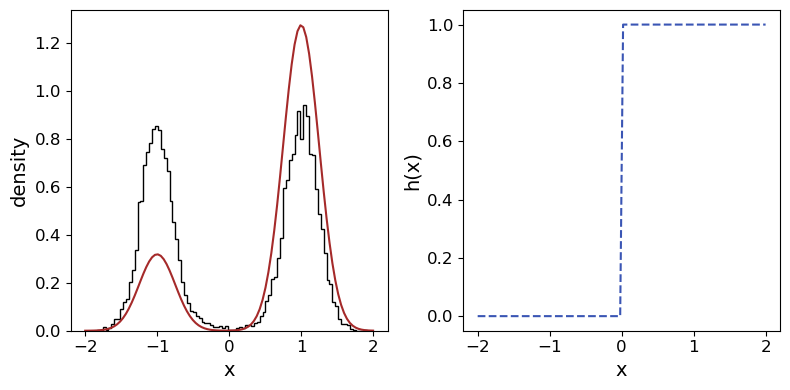

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
bins = torch.linspace(-2.0, 2.0, 100)
axs[0].hist(samps.reshape(-1), bins, histtype="step", color="black", density=True)

# Maximum entropy solution
alpha_star = log(hstar * 0.5 / (0.5 * (1 - hstar)))
density_fn = (
    lambda x: gmm.density(x.unsqueeze(-1))
    * torch.exp(alpha_star * (x >= 0).float())
    / (exp(alpha_star) * 0.5 + 0.5)
)
plot_1d_density(density_fn, ax=axs[0], xlim=(-2, 2), color=colors[1])
axs[1].plot(
    bins,
    (lambda x: (x >= 0.0).to(torch.float32))(bins),
    color=colors[0],
    linestyle="dashed",
)
axs[1].tick_params(axis='both', which='major', labelsize=labelsize)
axs[1].set_xlabel("x", fontsize=fontsize)
axs[1].set_ylabel("h(x)", fontsize=fontsize)


plt.tight_layout()
plt.show()

### Calibrating the base model with CGM-relax

For CGM-relax, we minimize the relax loss
\begin{align*}
    \mathcal{L}^{\text{relax}} = \underbrace{\|\mathbb{E}[\boldsymbol{h}(\boldsymbol{x})]- \boldsymbol{h}^\ast \|^2}_{\mathcal{L}^{\text{viol}}} + \lambda \underbrace{\text{D}_{\text{KL}}(p_{\theta}||p_{\theta_{\text{base}}})}_{\mathcal{L}^{\text{KL}}}.
\end{align*}
We need to specify the hyperparameter $\lambda$, which trades off between the violation loss $\mathcal{L}^{\text{viol}}$ and the KL divergence to the base model $\mathcal{L}^{\text{KL}}$. We choose $\lambda$ based upon the grid search we performed for our synthetic data experiments.

Training Epochs: 100%|██████████| 100/100 [00:36<00:00,  2.75it/s, loss=0.0044, viol=-0.0016, kl=0.2411]


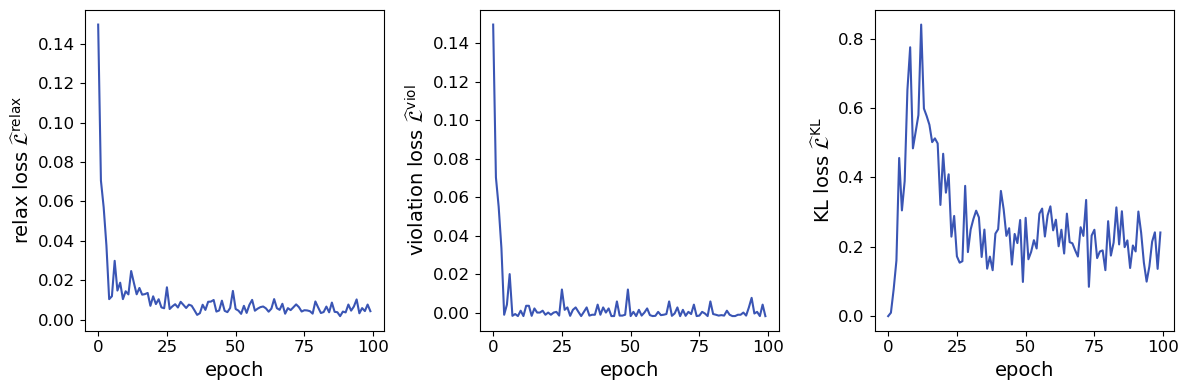

In [16]:
lambd = 0.025
batch_size = 100
epochs = 100
logger = DictLogger()

relax_model = calibrate_relaxed(
    clone_network(
        base_model, disable_gradients=False
    ),  # clone the base model so we can keep our original copy of it
    h,
    torch.tensor([hstar], device=device),
    lambd,
    epochs,
    batch_size,
    logger=logger,
)
plot_logger(logger)

Visualize samples from the calibrated model:

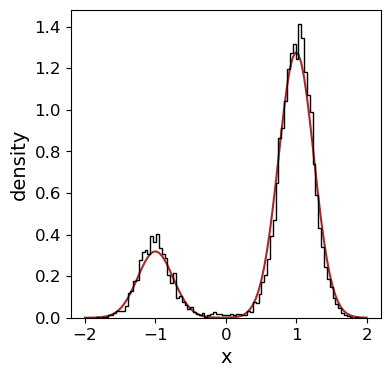

In [17]:
with torch.no_grad():
    samps = relax_model.sample(Nsamps)  # sample from the learned backward process
samps = samps.xs[:, -1, 0].cpu()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_1d_density(density_fn, ax=ax, xlim=(-2, 2), color=colors[1])
ax.hist(samps.reshape(-1), bins, histtype="step", color="black", density=True)
plt.show()

Since the maximum entropy solution is approximately equal to $q_{\text{calibrated}}$, we can use the analytical backward process corresponding to $q_{\text{calibrated}}$ to determine whether the backward process we learned is approximately correct.

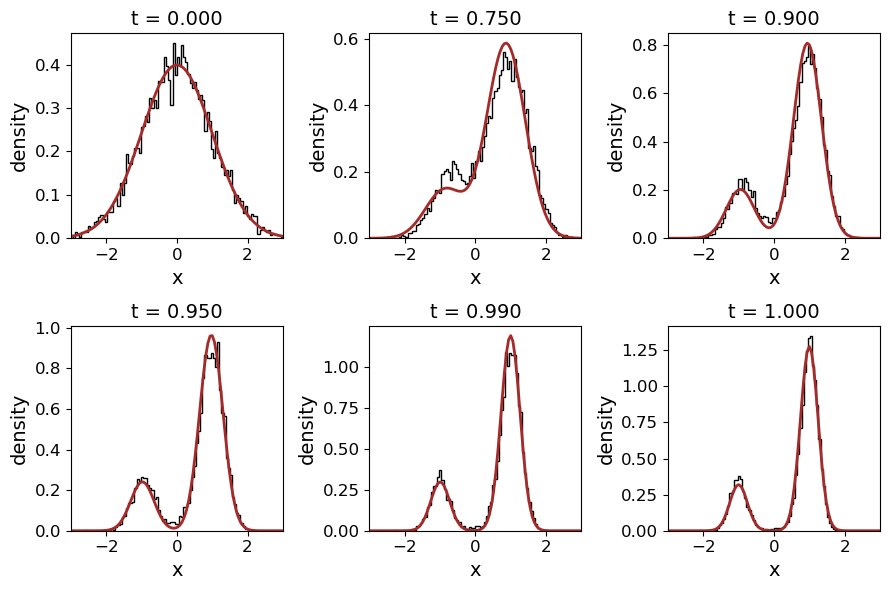

In [18]:
gmm_calibrated = GMM(means, cov, torch.tensor([1.0 - hstar, hstar]))
plot_marginals_and_gmm_density(relax_model, gmm_calibrated, Nsamps=Nsamps)

### CGM-reward

For CGM-reward, we minimize the reward loss
\begin{align*}
\text{D}_{\text{KL}}(p_{\theta} || p_{\boldsymbol{\alpha}^\ast}) = \underbrace{\text{D}_{\text{KL}}(p_{\theta} || p_{\theta_{\text{base}}})}_{\mathcal{L}^\text{KL}} + \underbrace{\mathbb{E}_{p_{\theta}}[-r_{\widehat{\boldsymbol{\alpha}}_N}(\boldsymbol{x})]}_{\mathcal{L}^\text{r}} + C, \quad r_{\boldsymbol{\alpha}}(\boldsymbol{x}) = \boldsymbol{\alpha}^\top \boldsymbol{h}(\boldsymbol{x})
\end{align*}
where $C$ is the normalizing constant of $p_{\widehat{\boldsymbol{\alpha}}_N}$ that does not depend on $\theta$. The reward loss represents the KL divergence between the generative model $p_{\theta}$ and the maximum entropy distribution $p_{\boldsymbol{\alpha}^\ast}$. Minimizing the reward loss is equivalent to a reward fine-tuning problem with choice of reward $r_{\boldsymbol{\alpha}}(\boldsymbol{x})$.

For CGM-reward, the hyperparameter that we need to specify is $N$, the number of samples we use when estimating $\boldsymbol{\alpha}^*$, the parameters of the maximum entropy solution, by $\widehat{\boldsymbol{\alpha}}_N$.

Training Epochs: 100%|██████████| 100/100 [00:36<00:00,  2.75it/s, loss=-0.8833, viol=-0.0011, kl=0.2093]


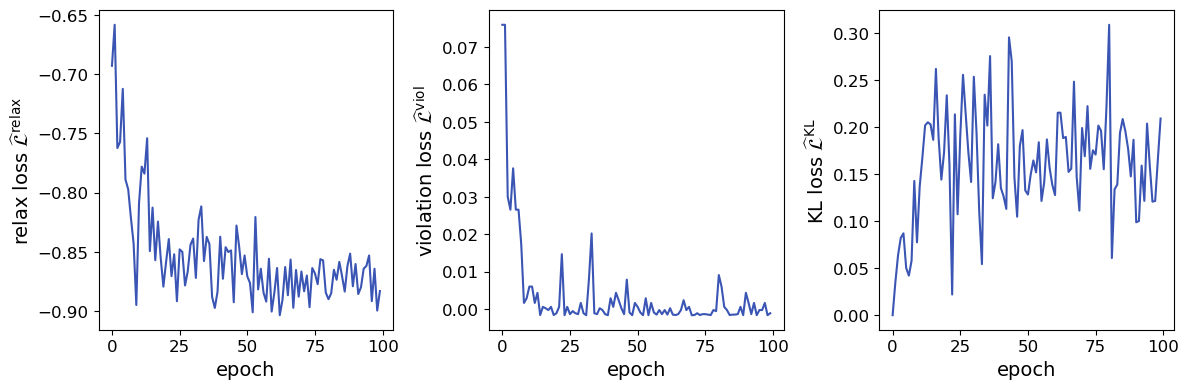

In [19]:
N = 10**4
logger = DictLogger()
reward_model = calibrate_reward(
    clone_network(base_model, disable_gradients=False),
    h,
    torch.tensor([hstar], device=device),
    N,
    epochs,
    batch_size,
    logger=logger,
)
plot_logger(logger)

Visualize samples from the calibrated model:

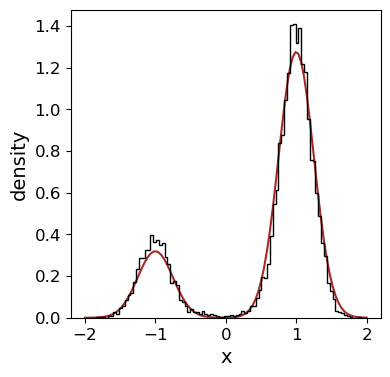

In [20]:
with torch.no_grad():
    samps = reward_model.sample(Nsamps)  # sample from the learned backward process
samps = samps.xs[:, -1, 0].cpu()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_1d_density(density_fn, ax=ax, xlim=(-2, 2), color=colors[1])
ax.hist(samps.reshape(-1), bins, histtype="step", color="black", density=True)
plt.show()

And compare to the backward process for $q_{\text{calibrated}}$:

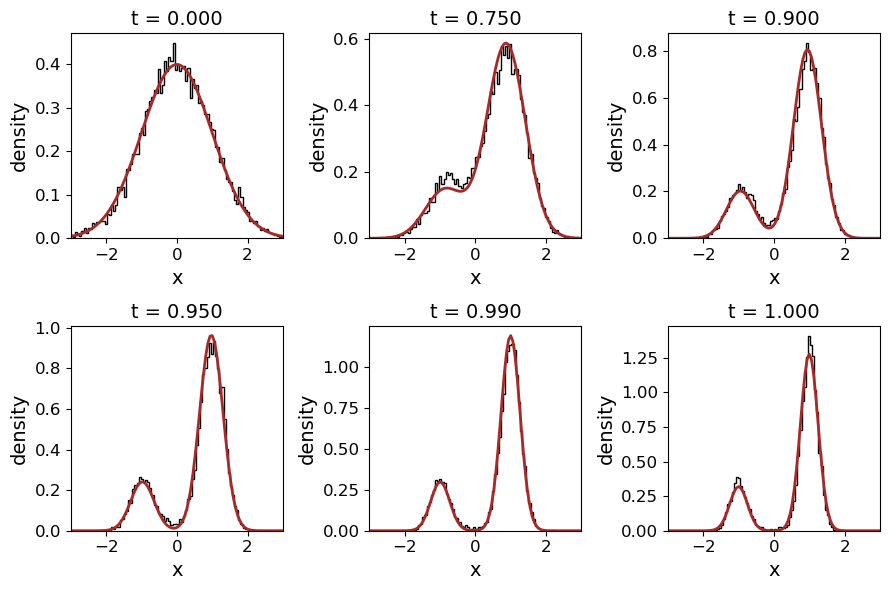

In [21]:
plot_marginals_and_gmm_density(reward_model, gmm_calibrated, Nsamps=Nsamps)